In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [2]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 50
batch_size = 50
learning_rate = 0.1

M_train = 1000
M_test = 200

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [4]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [5]:
# Train the model

model_RealData = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model_RealData)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_RealData.parameters(), lr=learning_rate)

def train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RealData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model_RealData.input_layer.weight.grad).tolist()
        batch_gradient+=model_RealData.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model_RealData.output_layer.weight.grad).tolist()
        batch_gradient+=model_RealData.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1

        optimizer.step()

        
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
    k=len(train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*M_train

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    train_loss.append(trainloss)
    alpha_list.append(alpha)
    train_accuracy.append(accuracy(train_loader))
    test_loss.append(loss(test_loader))
    test_accuracy.append(accuracy(test_loader))
    epoch_list.append(epoch)
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,train_loss[-1],test_loss[-1],train_accuracy[-1],test_accuracy[-1],alpha_list[-1]))

Epoch: 1 TrainLoss: 0.904 TestLoss: 1.086 TrainAccuracy: 0.798 TestAccuracy: 0.710 Coherence: 12.660
Epoch: 2 TrainLoss: 0.511 TestLoss: 0.736 TrainAccuracy: 0.883 TestAccuracy: 0.800 Coherence: 4.856
Epoch: 3 TrainLoss: 0.336 TestLoss: 0.584 TrainAccuracy: 0.907 TestAccuracy: 0.855 Coherence: 2.619
Epoch: 4 TrainLoss: 0.405 TestLoss: 0.520 TrainAccuracy: 0.920 TestAccuracy: 0.845 Coherence: 2.120
Epoch: 5 TrainLoss: 0.310 TestLoss: 0.477 TrainAccuracy: 0.931 TestAccuracy: 0.870 Coherence: 1.733
Epoch: 6 TrainLoss: 0.241 TestLoss: 0.443 TrainAccuracy: 0.940 TestAccuracy: 0.870 Coherence: 1.333
Epoch: 7 TrainLoss: 0.189 TestLoss: 0.401 TrainAccuracy: 0.941 TestAccuracy: 0.900 Coherence: 1.441
Epoch: 8 TrainLoss: 0.224 TestLoss: 0.383 TrainAccuracy: 0.953 TestAccuracy: 0.900 Coherence: 1.014
Epoch: 9 TrainLoss: 0.243 TestLoss: 0.372 TrainAccuracy: 0.955 TestAccuracy: 0.905 Coherence: 1.076
Epoch: 10 TrainLoss: 0.225 TestLoss: 0.354 TrainAccuracy: 0.968 TestAccuracy: 0.905 Coherence: 1.21

Text(0.5, 1.0, 'Coherence Against Loss')

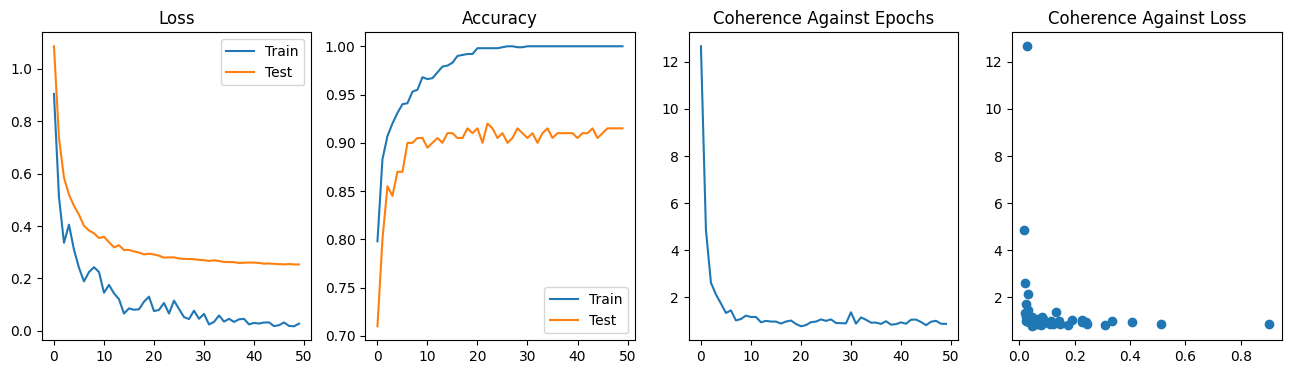

In [6]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].scatter(np.flip(train_loss), alpha_list)
axs[3].set_title('Coherence Against Loss')

In [7]:
batch_size = 25

In [8]:
# MNIST dataset 
random_train_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y, 
                                           download=True)

random_test_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y)

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_random_train_dataset=Subset(random_train_dataset, reduced_train_index)
subset_random_test_dataset=Subset(random_test_dataset, reduced_test_index)

# Data loader
random_train_loader = DataLoader(dataset=subset_random_train_dataset, batch_size=batch_size, shuffle=True)

random_test_loader = DataLoader(dataset=subset_random_test_dataset, batch_size=batch_size, shuffle=False) 

In [9]:
model_RandomData = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model_RandomData)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_RandomData.parameters(), lr=learning_rate) 

def r_train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for images, labels in random_train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RandomData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model_RandomData.input_layer.weight.grad).tolist()
        batch_gradient+=model_RandomData.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model_RandomData.output_layer.weight.grad).tolist()
        batch_gradient+=model_RandomData.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1

        optimizer.step()

    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
    k=len(random_train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*M_train

def r_accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def r_loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

random_train_loss=[]
random_train_accuracy=[]
random_test_loss=[]
random_test_accuracy=[]
random_alpha_list=[]

for epoch in range(num_epochs):
    random_trainloss, random_alpha = r_train_epoch()
    random_train_loss.append(random_trainloss)
    random_alpha_list.append(random_alpha)
    random_train_accuracy.append(r_accuracy(random_train_loader))
    random_test_loss.append(r_loss(random_test_loader))
    random_test_accuracy.append(r_accuracy(random_test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,random_train_loss[-1],random_test_loss[-1],random_train_accuracy[-1],random_test_accuracy[-1],random_alpha_list[-1]))

Epoch: 1 TrainLoss: 1.485 TestLoss: 1.491 TrainAccuracy: 0.517 TestAccuracy: 0.495 Coherence: 1.040
Epoch: 2 TrainLoss: 1.110 TestLoss: 1.385 TrainAccuracy: 0.541 TestAccuracy: 0.460 Coherence: 0.410
Epoch: 3 TrainLoss: 1.051 TestLoss: 1.300 TrainAccuracy: 0.564 TestAccuracy: 0.510 Coherence: 0.299
Epoch: 4 TrainLoss: 1.071 TestLoss: 1.255 TrainAccuracy: 0.584 TestAccuracy: 0.510 Coherence: 0.276
Epoch: 5 TrainLoss: 1.054 TestLoss: 1.156 TrainAccuracy: 0.588 TestAccuracy: 0.545 Coherence: 0.276
Epoch: 6 TrainLoss: 1.048 TestLoss: 1.131 TrainAccuracy: 0.593 TestAccuracy: 0.480 Coherence: 0.247
Epoch: 7 TrainLoss: 1.059 TestLoss: 1.111 TrainAccuracy: 0.609 TestAccuracy: 0.515 Coherence: 0.285
Epoch: 8 TrainLoss: 0.905 TestLoss: 1.171 TrainAccuracy: 0.610 TestAccuracy: 0.500 Coherence: 0.275
Epoch: 9 TrainLoss: 0.927 TestLoss: 1.070 TrainAccuracy: 0.602 TestAccuracy: 0.550 Coherence: 0.301
Epoch: 10 TrainLoss: 1.071 TestLoss: 1.087 TrainAccuracy: 0.599 TestAccuracy: 0.520 Coherence: 0.293

Text(0.5, 1.0, 'Coherence Against Loss')

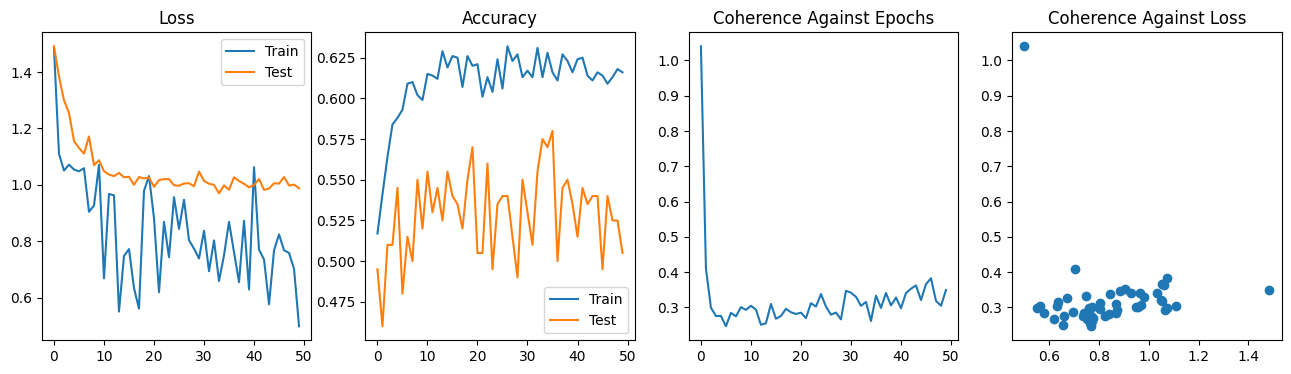

In [10]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), random_alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].scatter(np.flip(random_train_loss), random_alpha_list)
axs[3].set_title('Coherence Against Loss')

Here approximately $50$% of the data is clean and the rest is randomized. Hence, we see that accuracy is much lower than the clean case.

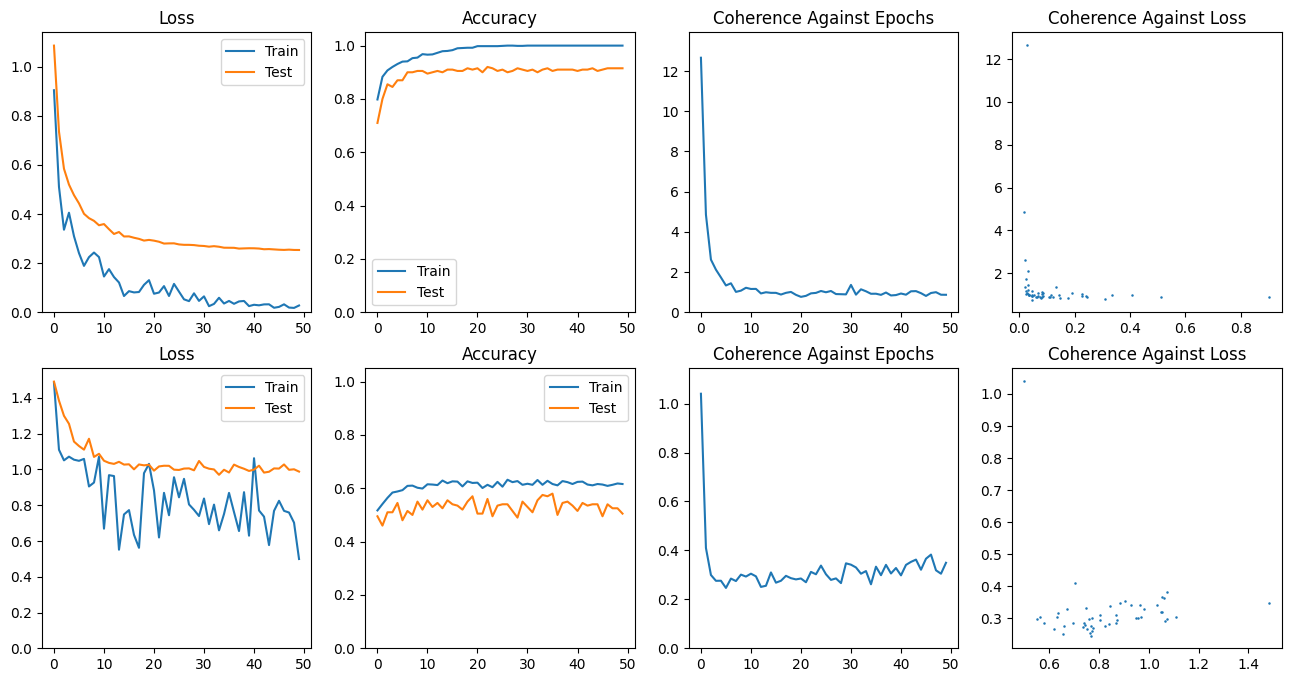

In [21]:
fig, axs = plt.subplots(2,4, figsize=(16,8))

axs[0,0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0,0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0,0].set_ylim((0,max([max(train_loss),max(test_loss)])*1.05))
axs[0,0].set_title('Loss')
axs[0,0].legend()
axs[0,1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[0,1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[0,1].set_ylim((0,1.05))
axs[0,1].set_title('Accuracy')
axs[0,1].legend()
axs[0,2].plot(np.arange(num_epochs), alpha_list)
axs[0,2].set_title('Coherence Against Epochs')
axs[0,2].set_ylim((0,max(alpha_list)*1.1))
axs[0,3].plot(np.flip(train_loss), alpha_list,'o', markersize=0.8)
axs[0,3].set_title('Coherence Against Loss')

axs[1,0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[1,0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[1,0].set_ylim((0,max([max(random_train_loss),max(random_test_loss)])*1.05))
axs[1,0].set_title('Loss')
axs[1,0].legend()
axs[1,1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1,1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1,1].set_ylim((0,1.05))
axs[1,1].set_title('Accuracy')
axs[1,1].legend()
axs[1,2].plot(np.arange(num_epochs), random_alpha_list)
axs[1,2].set_title('Coherence Against Epochs')
axs[1,2].set_ylim((0,max(random_alpha_list)*1.1))
axs[1,3].plot(np.flip(random_train_loss), random_alpha_list,'o', markersize=0.8)
axs[1,3].set_title('Coherence Against Loss')

plt.savefig('plots/coherence_MNIST.png')